# Tutoriel Accident auto
Data from Kaggle [US Accidents](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents).

In this tutorial, the data are not loaded raw. A data preparation to facilitate the use of the tutorial has been done. You can find it here: [Eurybia - Data Preparation](https://github.com/MAIF/eurybia/blob/master/eurybia/data/dataprep_US_car_accidents.ipynb).

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import catboost
from category_encoders import OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

In [5]:
df_car_accident = pd.read_csv('https://github.com/MAIF/shapash/raw/master/data/US_Accidents_extract.csv', header=0, engine='python')

In [6]:
df_car_accident.head()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),day_of_week_acc,Nautical_Twilight,season_acc,target,target_multi,year_acc,Description
0,33.0,-117.1,0.0,40.0,93.0,2.0,3,Day,winter,0,2,2019,At Carmel Mountain Rd - Accident.
1,29.5,-98.5,0.0,83.0,65.0,10.0,4,Day,summer,1,3,2017,At TX-345-SP/Woodlawn Ave/Exit 567B - Accident.
2,32.7,-96.8,0.0,88.0,57.0,10.0,0,Night,summer,0,2,2021,Incident on RUGGED DR near BERKLEY AVE Expect ...
3,40.0,-76.3,0.0,61.0,58.0,10.0,4,Day,spring,0,2,2020,At PA-741/Rohrerstown Rd - Accident.
4,41.5,-81.8,1.0,71.0,53.0,10.0,0,Day,summer,0,2,2020,At 117th St/Exit 166 - Accident.


In [7]:
y = df_car_accident["target"]
X = df_car_accident.drop(["target", "target_multi", "year_acc", "Description"], axis=1)

features = [
    "Start_Lat",
    "Start_Lng",
    "Distance(mi)",
    "Temperature(F)",
    "Humidity(%)",
    "Visibility(mi)",
    "day_of_week_acc",
    "Nautical_Twilight",
    "season_acc",
]

In [8]:
features_to_encode = [
    col for col in X[features].columns if X[col].dtype not in ("float64", "int64")
]

encoder = OrdinalEncoder(cols=features_to_encode)
encoder = encoder.fit(X[features])
X_encoded = encoder.transform(X)

In [9]:
features_to_encode = [
    col for col in X[features].columns if X[col].dtype not in ("float64", "int64")
]

encoder = OrdinalEncoder(cols=features_to_encode)
encoder = encoder.fit(X[features])
X_encoded = encoder.transform(X)

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_encoded, y, train_size=0.75, random_state=1
)

model = catboost.CatBoostClassifier()
model.fit(Xtrain, ytrain, verbose=False)

In [11]:
ypred=pd.DataFrame(model.predict(Xtest),columns=['pred'],index=Xtest.index)

In [12]:
from shapash import SmartExplainer

In [13]:
features_dict = {
    "day_of_week_acc": "Day of week",
    "season_acc": "Season"
}

xpl = SmartExplainer(
    model=model,
    preprocessing=encoder, # Optional: compile step can use inverse_transform method
    features_dict=features_dict, # Optional: specifies label for features name
)

In [14]:
additional_data = df_car_accident.loc[Xtest.index, ["year_acc", "Description"]]
additional_features_dict = {"year_acc": "Year"}

In [15]:
xpl.compile(
    x=Xtest, 
    y_pred=ypred, # Optional: for your own prediction (by default: model.predict)
    y_target=ytest, # Optional: allows to display True Values vs Predicted Values
    additional_data=additional_data, # Optional: additional dataset of features for Webapp
    additional_features_dict=additional_features_dict, # Optional: specifies label for additional features name
)

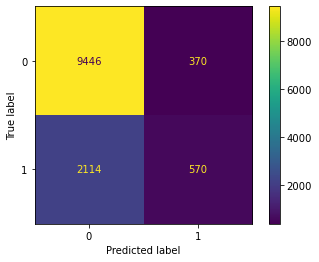

In [16]:
cm = confusion_matrix(ytest, ypred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [17]:
xpl.plot.scatter_plot_prediction()

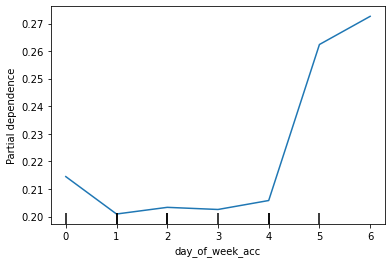

In [21]:
PartialDependenceDisplay.from_estimator(model, Xtest, ["day_of_week_acc"])

In [22]:
xpl.plot.contribution_plot(col="day_of_week_acc")